In [1]:
### PREPROCESSING (Imports) - Import necessary libraries for preprocessing
from typing import List, Dict, Tuple
from typing import overload, Literal, Union

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.cluster import Birch
from hdbscan import HDBSCAN

from sklearn.metrics import davies_bouldin_score, accuracy_score, classification_report, confusion_matrix

In [2]:
###  PREPROCESSING - Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

In [3]:
###  PREPROCESSING (Function definitions) - Data introduction
# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

# Split training and testing data
def split_data(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame]:
    X = df.copy()
    Y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1/3)
    return x_train, x_test, y_train, y_test

# Sampling

def oversample(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame]:
    x = df.drop(columns=target)
    y = df[target]

    ROS = SMOTE(sampling_strategy="auto")
    x_res, y_res = ROS.fit_resample(x, y)
    return x_res, y_res

def sampling(df: pd.DataFrame, rate: float, cap1=0, cap2=0, notext=False) -> pd.DataFrame:
    if notext == False:
        print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
        print("Sampling ...")

    if cap1 != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        if cap2 != 0:
            subtypes_sampling1 = subtype_counts[(subtype_counts > cap1) & (subtype_counts < 10*cap2)].index
            subtypes_sampling2 = subtype_counts[subtype_counts >= 10*cap2].index
        
        else:
             subtypes_sampling = subtype_counts[subtype_counts > cap1].index
        subtypes_nosampling = subtype_counts[subtype_counts <= cap1].index # All the traffic subtypes with under x rows
        
        if cap2 != 0:
            df_sampling1 = df[df["Traffic Subtype"].isin(subtypes_sampling1)]
            df_sampled1 = df_sampling1.sample(frac=rate)
            df_sampling2 = df[df["Traffic Subtype"].isin(subtypes_sampling2)]
            df_sampled2 = df_sampling2.sample(frac=rate/10)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled1, df_sampled2, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

        else:
            df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]
            df_sampled = df_sampling.sample(frac=rate)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)
        
    if notext == False:
        print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final.sample(frac=1, ignore_index=True)

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame) -> pd.DataFrame:
    print("\n\nSampled dataset:")
    print("Dataset after uniform target sampling has", df.shape[0], "rows and", df.shape[1], "columns")

    display(df.head())
    display(df.tail())

    df_details = df.describe()
    display(df_details.T)

    display(df.groupby(["Label"]).size().reset_index(name="Counts"))
    display(df.groupby(["Traffic Type"]).size().reset_index(name="Counts"))
    
    return df_details

In [38]:
###  PREPROCESSING (Function definitions) - Correlation, target correlation and importaant metrics
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}
SUBTYPES_MAPPER = {
    "Audio": 0, "Background": 1, "Text": 2, "Video HTTP": 3, "Video RTP": 4, "Video UDP": 5, "Bruteforce DNS": 6, "Bruteforce FTP": 7, "Bruteforce HTTP": 8,
    "Bruteforce SSH": 9, "Bruteforce Telnet": 10, "DoS ACK": 11, "DoS CWR": 12, "DoS ECN": 13, "DoS FIN": 14, "DoS HTTP": 15, "DoS ICMP": 16, "DoS MAC": 17,
    "DoS PSH": 18, "DoS RST": 19, "DoS SYN": 20, "DoS UDP": 21, "DoS URG": 22, "Information Gathering": 23, "Mirai DDoS ACK": 24, "Mirai DDoS DNS": 25,
    "Mirai DDoS GREETH": 26, "Mirai DDoS GREIP": 27, "Mirai DDoS HTTP": 28, "Mirai DDoS SYN": 29, "Mirai DDoS UDP": 30, "Mirai Scan Bruteforce": 31
    }

# Targets to numerical
def labels_to_numerical(df: pd.DataFrame, mapper: Dict[str, int]) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: Dict[str, int]) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def subtypes_to_numerical(df: pd.DataFrame, mapper: Dict[str, int]) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Subtype"] = df_copy["Traffic Subtype"].map(mapper)
    return df_copy

#  PREPROCESSING - Correlation and overloading for different return types
@overload
def correlation(df_numerical: pd.DataFrame, target: str, with_target: Literal[True]) -> Tuple[pd.DataFrame, List[str]]: ...
@overload
def correlation(df_numerical: pd.DataFrame, target: str, with_target: Literal[False]) -> pd.DataFrame: ...
@overload
def correlation(df_numerical: pd.DataFrame, target: str, with_target: bool) -> Union[pd.DataFrame, Tuple[pd.DataFrame, List[str]]]: ...
    
def correlation(df_numerical: pd.DataFrame, target: str, with_target: bool) -> Union[pd.DataFrame, Tuple[pd.DataFrame, List[str]]]:
    df_copy = df_numerical.copy()
    df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())

    if with_target == True:
        important_metrics = []
        cor = df_norm.corr(numeric_only=True).filter([target])

        for r in cor.index.tolist():
            if abs(cor.at[r, target]) > 0.1:
                important_metrics.append(r)

        print(len(important_metrics) - 2, "Metrics with high correlation with", target)
        return cor, important_metrics

    else:
        return df_norm.corr(numeric_only=True)
    

In [14]:
###  PREPROCESSING (Function definitions) - Data Visualization
# Create heatmap from correlation Pandas Dataframes
def heatmap(corr_dict: dict, title: str, with_target=False) -> None:
    print("Generating heatmap ...")
    
    if with_target == True:
        final_corr = pd.DataFrame()
        for target in corr_dict.keys(): final_corr[target] = corr_dict[target]
        final_corr = final_corr.T
        plt.figure(figsize=(30, 5))
        sns.heatmap(final_corr, cmap="coolwarm", square=True, cbar=False)
        plt.xticks(rotation = 65, ha = "right")

    else:
        final_corr = corr_dict["Correlation"]
        plt.figure(figsize=(30, 20))
        sns.heatmap(final_corr, cmap="coolwarm", square=True)

    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, title: str, y_lim_bot: float, y_lim_top: float, x_labels: list) -> None:
    print("Generating boxplot ...")
    df_copy = df.copy()
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_copy)
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df_scaled)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right", labels=x_labels, ticks=[i for i in range(len(x_labels))])
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()



In [6]:
###  PREPROCESSING (Function definitions) - Dimensionality Reduction
PCA_COLS = [
    "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17",
    "PC18", "PC19", "PC20", "PC21", "PC22", "PC23", "PC24", "PC25", "PC26", "PC27", "PC28", "PC29", "PC30"
    ]

def dim_reduction(df: pd.DataFrame, N: int, method: str, notext=False) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)

        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])

        if notext == False:
            print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [7]:
###  PREPROCESSING (Function definitions) - Clustering
# BIRCH Algorithm
def BIRCH_clustering(df: pd.DataFrame, N_clusters: int, threshold=0.5) -> Tuple[pd.DataFrame, Birch]:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = Birch(n_clusters=N_clusters, threshold=threshold)
    model.fit(df_scaled)
    df["Cluster"] = model.labels_
    print(df["Cluster"].nunique(), "Clusters")

    cluster_index = davies_bouldin_score(df, model.labels_)
    print("Davies-Bouldin Index:", cluster_index)
    return df, model

# HDBSCAN Algorithm
def HDBSCAN_clustering(df: pd.DataFrame, minimum_cluster_size=5) -> Tuple[pd.DataFrame, HDBSCAN]:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = HDBSCAN(min_cluster_size=minimum_cluster_size)
    clusters = model.fit_predict(df_scaled)
    df["Cluster"] = clusters
    df_clean = df[df["Cluster"] != -1]
    print(df_clean["Cluster"].nunique(), "Clusters")
    
    clusters_clean = df_clean["Cluster"].to_numpy()
    cluster_index = davies_bouldin_score(df_clean, clusters_clean)
    print("Davies-Bouldin Index:", cluster_index)
    return df, model

# Evaluation of clusters
def evaluate_clusters(df: pd.DataFrame, target: str, subtarget: str, targets_n: int, cluster_ratio_cap=0.2, keep_problematic=False) -> pd.DataFrame:
    df_copy = df.copy()

    prediction_list = []
    counts = {}
    problematic_count = 0
    problematic_idx_count = {i: 0 for i in range(targets_n)}
    problematic_pop = 0
    empty_clusters = 0
    total_pop = len(df)
    total_clusters = df["Cluster"].nunique()
    target_total_pop = {i: 0 for i in range(targets_n)}
    target_actual_pop = {i: 0 for i in range(targets_n)}

    for cluster_id in range(total_clusters):
        class_counts = [len(df[(df["Cluster"] == cluster_id) & (df[target] == j)]) for j in range(targets_n)]
        if sum(class_counts) == 0:
            empty_clusters += 1
            continue
        dominant_class = np.argmax(class_counts)
        dominant_count = class_counts[dominant_class]
        other_count = sum(class_counts) - dominant_count
        prediction_list.append(dominant_class)
        if dominant_count == 0:
            print(class_counts)
            continue
        ratio = other_count / (dominant_count + other_count)
        if ratio > cluster_ratio_cap:  # Condition to identify problematic cluster
            problematic_count += 1
            problematic_pop += sum(class_counts)
            problematic_idx_count[dominant_class] += 1
            if keep_problematic == False:
                df_copy = df_copy.drop(df_copy[df_copy["Cluster"] == cluster_id].index)
        target_total_pop[dominant_class] += sum(class_counts)

    for i in range(targets_n):
        counts[i] = prediction_list.count(i)

    for i in range(targets_n):
        target_actual_pop[i] = len(df[df[target] == i])

    print("Problematic Cluster - Ratio: {0:.3f}%".format(problematic_count / total_clusters * 100))  # Ratio of clusters that are problematic
    print("Population that belongs to Problematic Clusters - Ratio: {0:.3f}%".format(problematic_pop / total_pop * 100))  # Ratio of total population that belongs to problematic clusters
    print("Clusters assigned to each {0}: {1}".format(target, counts))  # Amount of clusters that each target is assigned
    print("Problematic Clusters assigned to each {0}: {1}".format(target, problematic_idx_count)) # Amount of problematic clusters that each target is assigned
    print("Total Clusters:", total_clusters)  # Total number of clusters
    print("Empty clusters:", empty_clusters)  # Total number of empty clusters
    print("Total Population predicted per Target:", target_total_pop)  # Total population that was predicted for each target
    print("Real Population per Target:", target_actual_pop) # Real population of each target

    df_plot_x = df.groupby("Cluster")[target].mean()
    df_plot_y = df.groupby("Cluster")[subtarget].mean()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_plot_x.values, df_plot_y.values, c="red", marker="x", s=100, label="Cluster Centers")
    if target == "Label":
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.5, 7.5))
    elif target == "Traffic Type":
        plt.xlim((-0.5, 7.5))
        plt.ylim((-1, 32))
    plt.xlabel(target)
    plt.ylabel(subtarget)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df_copy
    

In [8]:
### PREPROCESSING (Function definitions) - Generate training data from clusters
def format_data(df: pd.DataFrame, target: str, targets_n: int) -> pd.DataFrame:
    cluster_counts = {}
    final_samples = []

    df_grouped = df.groupby("Cluster")
    df_mean = df_grouped.mean()
    df_labels = df_grouped[target].agg(lambda x: x.mode()[0])
    df_mean[target] = df_labels

    for i in range(targets_n): cluster_counts[i] = df[df[target] == i]["Cluster"].value_counts().count()  # Clusters per target
    most_clusters = max(cluster_counts.values())  # Maximum clusters for one target

    for i in range(targets_n):
        n_added = max(most_clusters - cluster_counts[i], 1)  # Samples to add for specific target
        df_target_data = df[df[target] == i]  # Data of specific target
        target_samples = df_target_data.sample(n=n_added, ignore_index=True, replace=True)  # Sampled data to add for specific target
        mean_rows = df_mean[df_mean[target] == i]  # Means of clusters for specific target
        samples = pd.concat([target_samples, mean_rows], ignore_index=True)
        "samples = mean_rows"
        final_samples.append(samples)

    df_sampled = pd.concat(final_samples, ignore_index=True)
    """for i in range(targets_n):
        print(len(df_sampled[df_sampled[target] == i]))"""
    df_final = df_sampled.sample(frac=1, ignore_index=True).drop(columns=["Cluster"])

    return df_final

In [9]:
### PREPROCESSING (Implementation) - Initial undersampling/oversampling remove excess metrics and duplicates in order to create plots in reasonable time, present data
ttype_list = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]

# Undersample large traffic subtypes to decrease data size
df_sampled = sampling(df_data, rate=0.005, cap1=5000, cap2=0)
df_sampled = drop_unnecessary(df_sampled)

# Split between training and testing data
split_list = split_data(df_sampled, "Label")
df_train = split_list[0]
df_test = split_list[1]

df_num = labels_to_numerical(df_train, LABEL_MAPPER)
df_num = ttypes_to_numerical(df_num, TYPES_MAPPER)
df_num = subtypes_to_numerical(df_num, SUBTYPES_MAPPER)

"""df_smoothed, y_train = oversample(df_num, "Traffic Type")
df_smoothed["Traffic Type"] = y_train"""

# Undersample again to get to desired data size and introduce slight randomizations
df = sampling(df_num, rate=0.8, notext=True)

# Present data
df_details = present(df)

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 61467 rows and 86 columns
Dataset before removing unnecessary data has 61467 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 61467 rows and 80 columns


Sampled dataset:
Dataset after uniform target sampling has 32782 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00       11278.00              3.00               1.00   
1      6.00    34766697.00              3.00               1.00   
2      6.00       13404.00              1.00               1.00   
3      6.00    14269580.00             38.00              45.00   
4      6.00      422862.00              1.00               1.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                        6.00                        0.00   
1                      130.00                        0.00   
2                       50.00                        0.00   
3                      354.00                      118.00   
4                       50.00                        0.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                   6.00                   0.00                    2.00   
1                  50.00                  30.00                   43.33   
2                  50.00                  50.00                   50.00   
3                  39.00                   0.00                    9.32   
4                  50.00                  50.00                   50.00   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   3.46                   0.00                   0.00   
1                  11.55                   0.00                   0.00   
2                   0.00                   0.00                   0.00   
3                   9.85                  12.00                   0.00   
4                   0.00                   0.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00        532.01   
1                    0.00                   0.00          3.74   
2                    0.00                   0.00       3730.23   
3                    2.62                   3.96         33.08   
4                    0.00                   0.00        118.24   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0          354.67        3759.33       3962.26       7915.00         24.00   
1            0.12    11588899.00   10466083.55   20408912.00      23864.00   
2          149.21       13404.00          0.00      13404.00      13404.00   
3            5.82      174019.27     682150.56    3307217.00         26.00   
4            4.73      422862.00          0.00     422862.00     422862.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0        7939.00       3969.50      5579.78      7915.00        24.00   
1    34742833.00   17371416.50   4295667.33  20408912.00  14333921.00   
2           0.00          0.00         0.00         0.00         0.00   
3    14262892.00     385483.57    989142.41   3354847.00        26.00   
4           0.00          0.00         0.00         0.00         0.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1           0.00          0.00         0.00         0.00         0.00   
2           0.00          0.00         0.00         0.00         0.00   
3    14264204.00     324186.45    910592.30   3311803.00        29.00   
4           0.00          0.00         0.00         0.00         0.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2           0.00           0.00           0.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0              96.00              20.00         266.00          88.67   
1              80.00              20.00           0.09  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
32777      6.00       46566.00              1.00               1.00   
32778      6.00       66887.00              1.00               1.00   
32779      6.00       59971.00              1.00               1.00   
32780     17.00    15057486.00              2.00               0.00   
32781      6.00        7113.00              3.00               1.00   

       Total Length of Fwd Packet  Total Length of Bwd Packet  \
32777                     1356.00                        0.00   
32778                       50.00                        0.00   
32779                       50.00                        0.00   
32780                     1000.00                        0.00   
32781                        6.00                        0.00   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
32777                1356.00                1356.00                 1356.00   
32778                  50.00                  50.00                   50.00   
32779                  50.00                  50.00                   50.00   
32780                 500.00                 500.00                  500.00   
32781                   6.00                   0.00                    2.00   

       Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
32777                   0.00                   0.00                   0.00   
32778                   0.00                   0.00                   0.00   
32779                   0.00                   0.00                   0.00   
32780                   0.00                   0.00                   0.00   
32781                   3.46                   0.00                   0.00   

       Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
32777                    0.00                   0.00      29119.96   
32778                    0.00                   0.00        747.53   
32779                    0.00                   0.00        833.74   
32780                    0.00                   0.00         66.41   
32781                    0.00                   0.00        843.53   

       Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
32777           42.95       46566.00          0.00      46566.00   
32778           29.90       66887.00          0.00      66887.00   
32779           33.35       59971.00          0.00      59971.00   
32780            0.13    15057486.00          0.00   15057486.00   
32781          562.35        2371.00       2299.85       4624.00   

       Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
32777      46566.00           0.00          0.00         0.00         0.00   
32778      66887.00           0.00          0.00         0.00         0.00   
32779      59971.00           0.00          0.00         0.00         0.00   
32780   15057486.00    15057486.00   15057486.00         0.00  15057486.00   
32781         27.00        2489.00       1244.50      1721.81      2462.00   

       Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
32777         0.00           0.00          0.00         0.00         0.00   
32778         0.00           0.00          0.00         0.00         0.00   
32779         0.00           0.00          0.00         0.00         0.00   
32780  15057486.00           0.00          0.00         0.00         0.00   
32781        27.00           0.00          0.00         0.00         0.00   

       Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
32777         0.00           0.00           0.00           0.00   
32778         0.00           0.00           0.00           0.00   
32779         0.00           0.00           0.00           0.00   
32780         0.00           0.00           0.00           0.00   
32781         0.00           0.00           0.00           0.00   

       Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  \
327

count       mean         std     min      25%  \
Protocol                   32782.00       6.37        2.09    0.00     6.00   
Flow Duration              32782.00 9320291.89 14682465.43    5.00 46775.50   
Total Fwd Packet           32782.00      68.13     3010.61    1.00     1.00   
Total Bwd packets          32782.00      43.03     1610.81    0.00     1.00   
Total Length of Fwd Packet 32782.00   20360.67   446381.20    0.00    33.25   
Total Length of Bwd Packet 32782.00   19621.67   333751.61    0.00     0.00   
Fwd Packet Length Max      32782.00     266.20      368.37    0.00    17.00   
Fwd Packet Length Min      32782.00     222.26      346.58    0.00     0.00   
Fwd Packet Length Mean     32782.00     230.22      345.38    0.00     4.14   
Fwd Packet Length Std      32782.00      12.24       49.83    0.00     0.00   
Bwd Packet Length Max      32782.00      56.84      232.01    0.00     0.00   
Bwd Packet Length Min      32782.00       0.22        8.34    0.00     0.00   
Bwd Packet Length Mean     32782.00      14.53      110.52    0.00     0.00   
Bwd Packet Length Std      32782.00      12.38       50.01    0.00     0.00   
Flow Bytes/s               32782.00    7687.20    57277.65    0.00    13.65   
Flow Packets/s             32782.00     370.16     5564.97    0.03     0.30   
Flow IAT Mean              32782.00 3619379.87  6251990.42    5.00 41356.00   
Flow IAT Std               32782.00 1831237.75  4045530.63    0.00     0.00   
Flow IAT Max               32782.00 5905292.02  8695978.75    5.00 46279.75   
Flow IAT Min               32782.00 2285250.20  5701309.38 -945.00  9963.00   
Fwd IAT Total              32782.00 8724353.36 14476049.05    0.00     0.00   
Fwd IAT Mean               32782.00 4091106.47  7008190.88    0.00     0.00   
Fwd IAT Std                32782.00 1043708.94  2848237.23    0.00     0.00   
Fwd IAT Max                32782.00 5567551.45  8503508.63    0.00     0.00   
Fwd IAT Min                32782.00 3393873.71  6709045.70    0.00     0.00   
Bwd IAT Total              32782.00 2360024.32  8744060.37    0.00     0.00   
Bwd IAT Mean               32782.00  168812.44   602359.38    0.00     0.00   
Bwd IAT Std                32782.00  351098.16  1137233.60    0.00     0.00   
Bwd IAT Max                32782.00  884714.24  2845377.84    0.00     0.00   
Bwd IAT Min                32782.00    8048.74   270816.24    0.00     0.00   
Fwd PSH Flags              32782.00       0.10        0.30    0.00     0.00   
Bwd PSH Flags              32782.00       0.00        0.00    0.00     0.00   
Fwd URG Flags              32782.00       0.08        0.27    0.00     0.00   
Bwd URG Flags              32782.00       0.00        0.00    0.00     0.00   
Fwd Header Length          32782.00     896.39     8618.90    0.00    20.00   
Bwd Header Length          32782.00     766.26     9314.70    0.00    20.00   
Fwd Packets/s              32782.00     303.23     5187.55    0.03     0.27   
Bwd Packets/s              32782.00      66.93     1166.51    0.00     0.02   
Packet Length Min          32782.00      80.36      250.31    0.00     0.00   
Packet Length Max          32782.00     288.30      391.25    0.00    50.00   
Packet Length Mean         32782.00     191.94      293.47    0.00    10.07   
Packet Length Std          32782.00      93.17      161.15    0.00     0.00   
Packet Length Variance     32782.00   34648.70   101406.69    0.00     0.00   
FIN Flag Count             32782.00       0.39        0.67    0.00     0.00   
SYN Flag Count             32782.00       0.46        1.58    0.00     0.00   
RST Flag Count             32782.00       0.81        0.62    0.00     0.00   
PSH Flag Count             32782.00      17.80      226.58    0.00     0.00   
ACK Flag Count             32782.00      43.45      512.20    0.00     1.00   
URG Flag Count             32782.00       0.14        0.59    0.00     0.00   
CWR Flag Count             32782.00       0.14        0.60    0.00     0.00   
E

Label  Counts
0      0     662
1      1   32120

Traffic Type  Counts
0             0     106
1             1      14
2             2     113
3             3     429
4             4    6985
5             5   20016
6             6    2821
7             7    2298

Generating boxplot ...


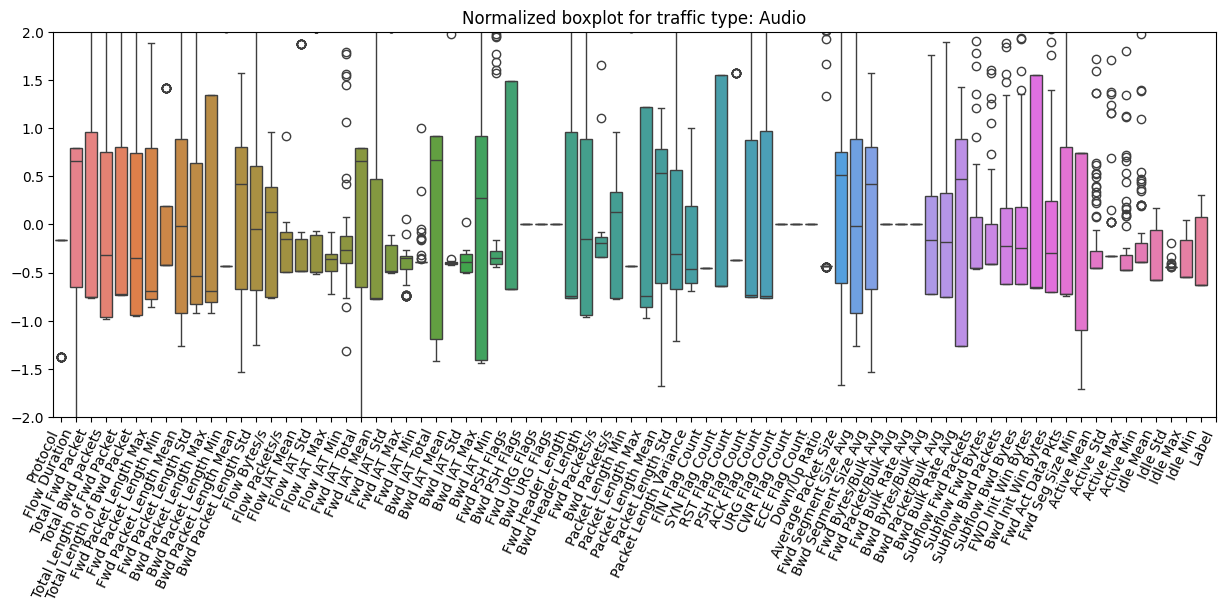

Generating boxplot ...


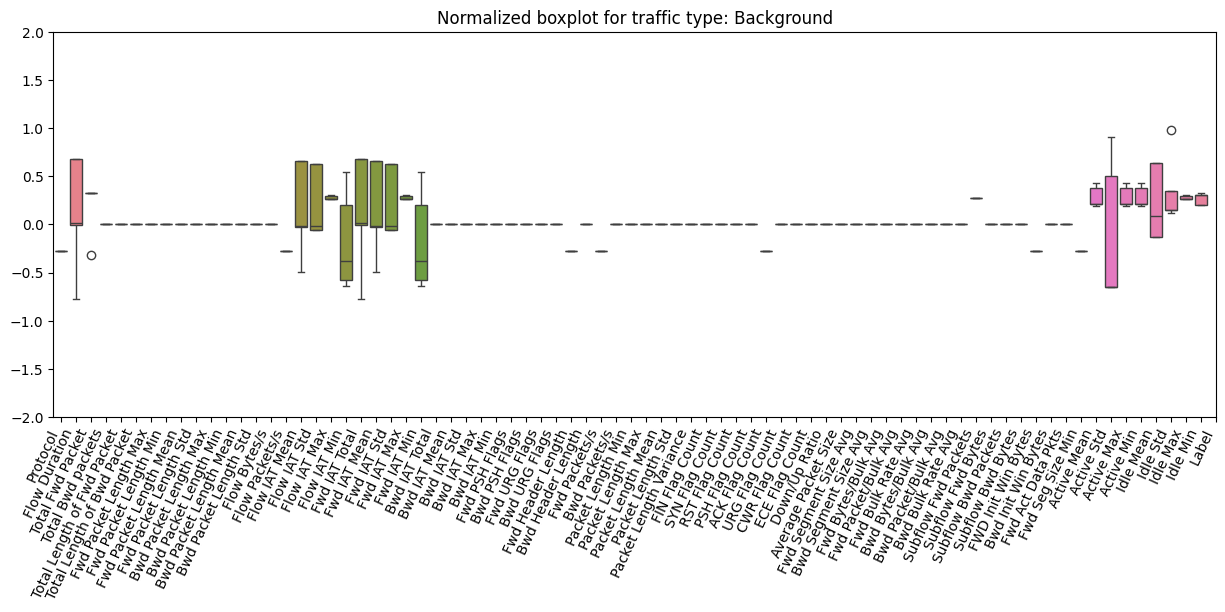

Generating boxplot ...


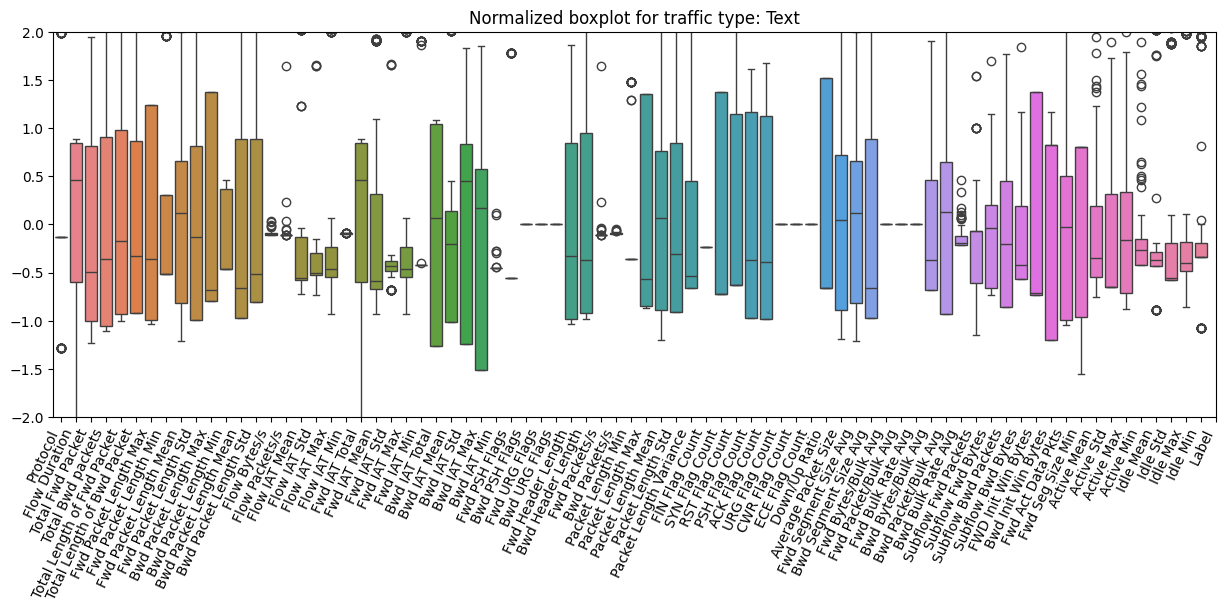

Generating boxplot ...


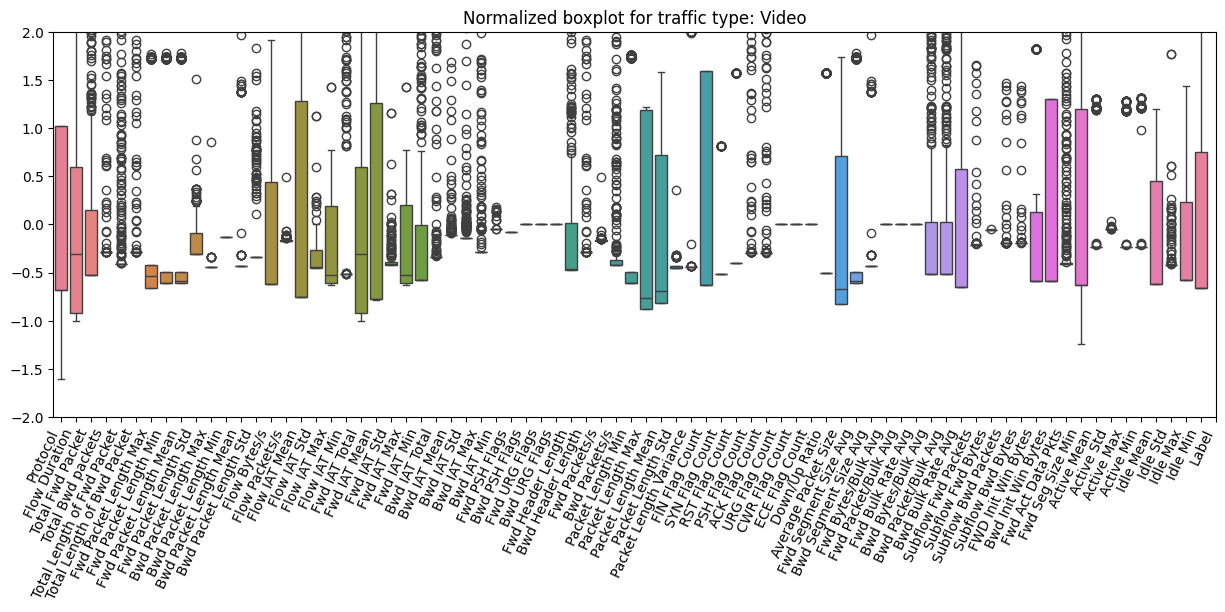

Generating boxplot ...


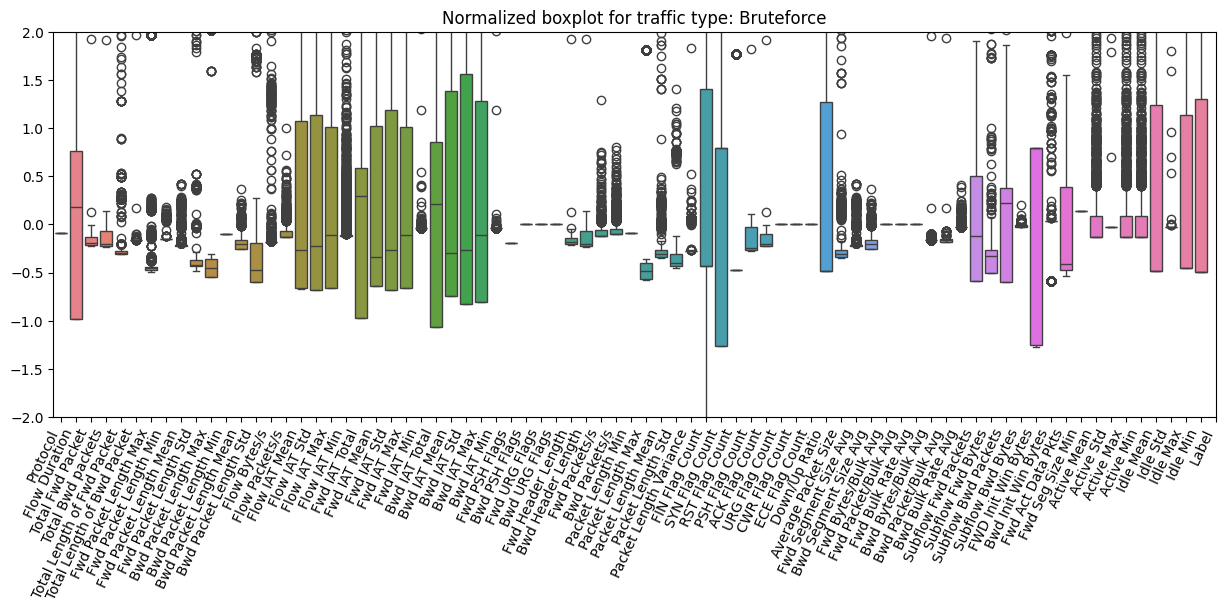

Generating boxplot ...


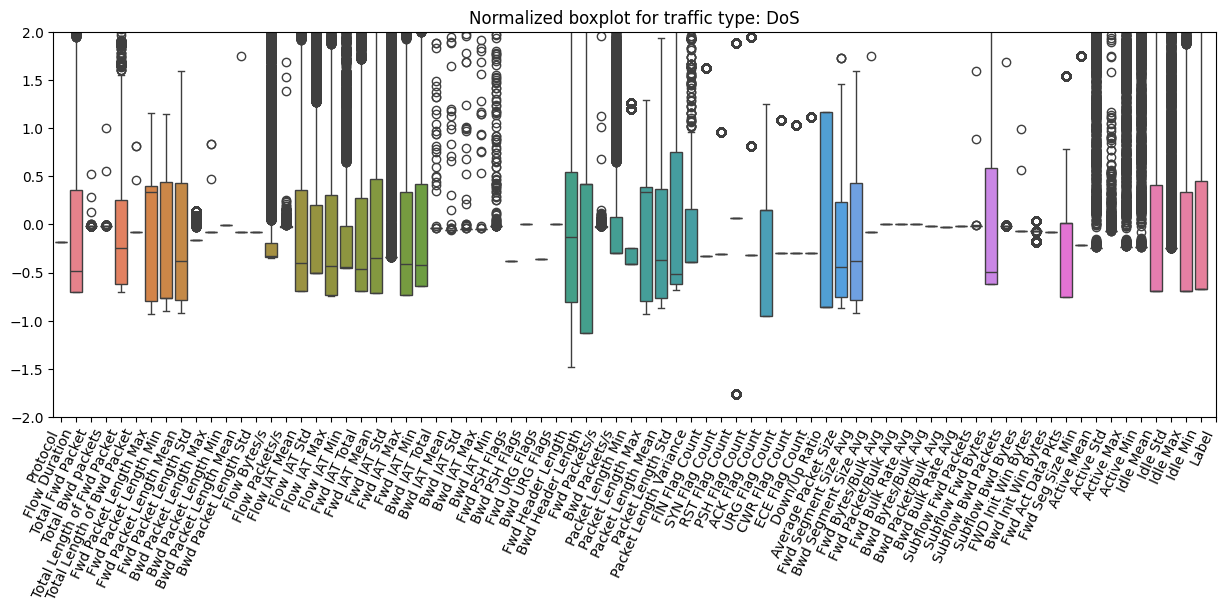

Generating boxplot ...


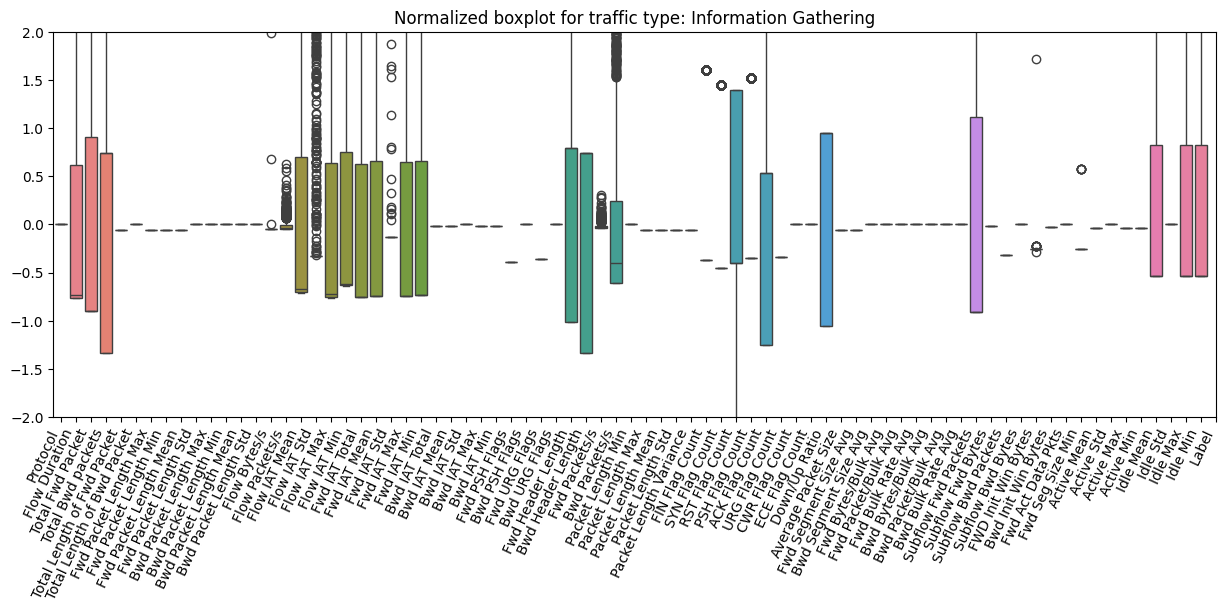

Generating boxplot ...


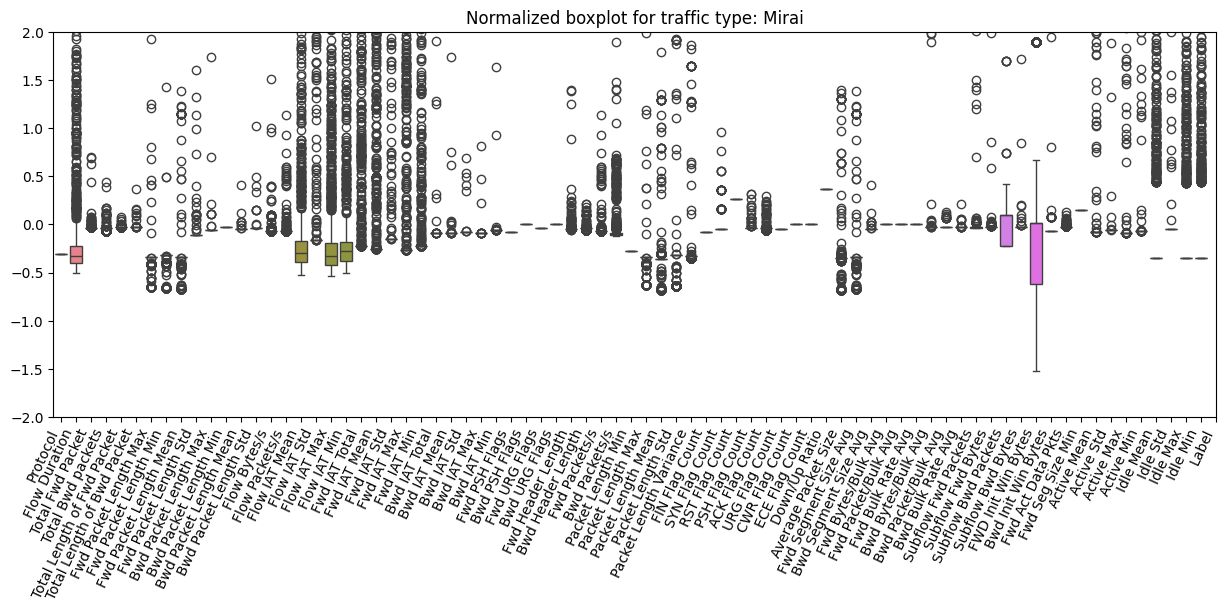

Generating boxplot ...


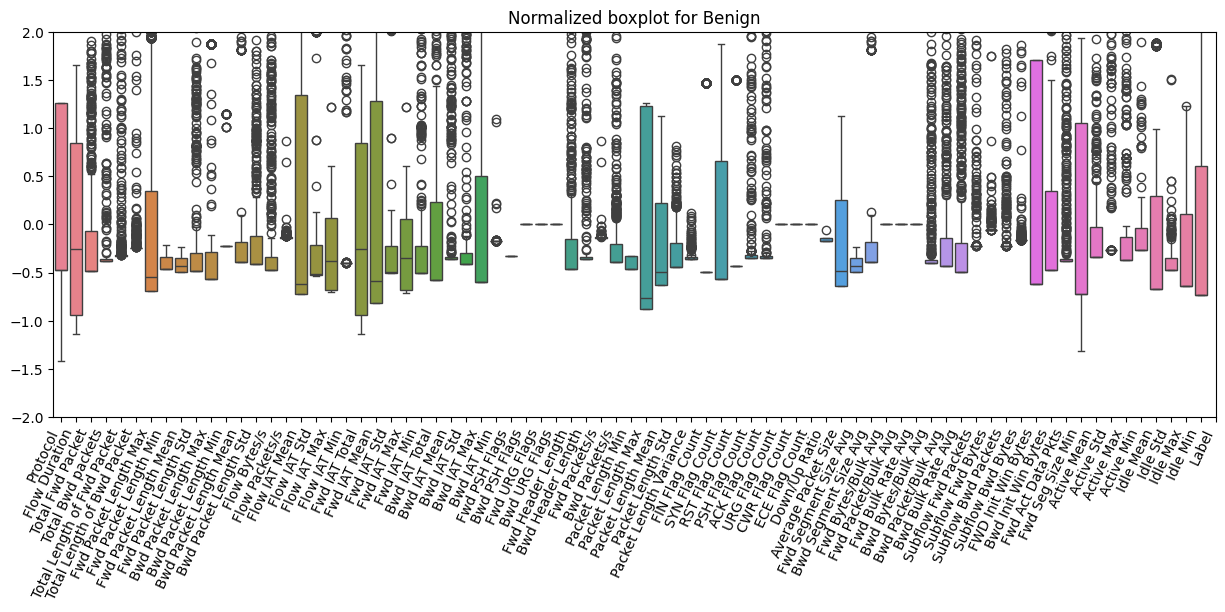

Generating boxplot ...


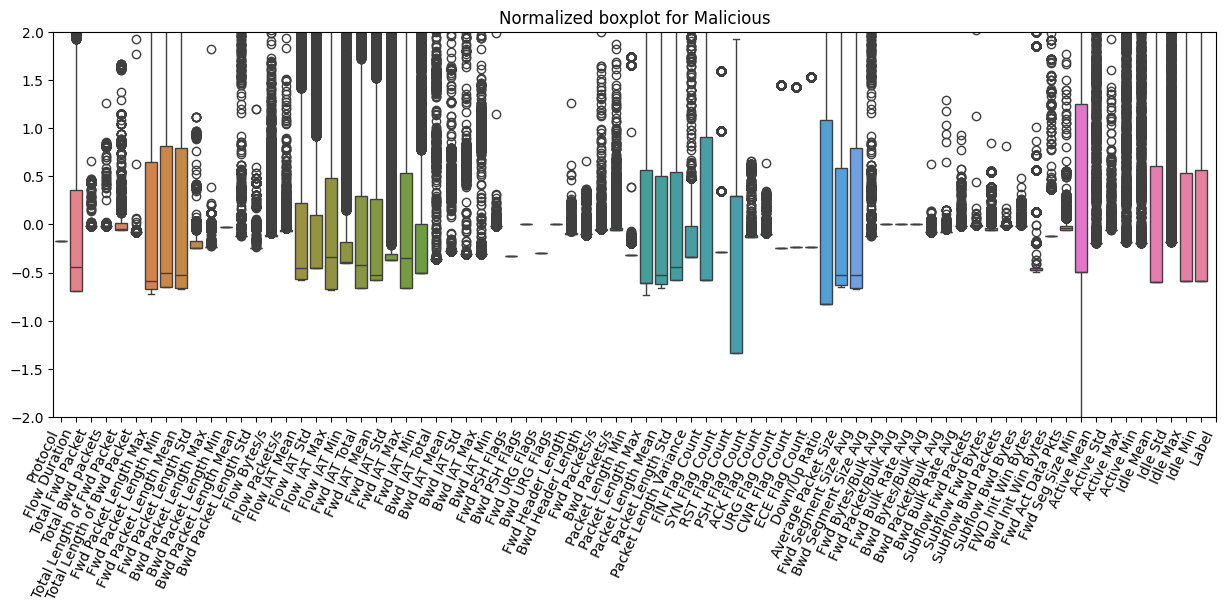

In [17]:
### PREPROCESSING (Implementation) - Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 2
ylim_bot = -2
df_benign = df[df["Label"] == 0].copy()
df_malicious = df[df["Label"] == 1].copy()

for ttype in range(8):
    boxplot(df[df["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype_list[ttype], ylim_bot, ylim_top, df.columns.tolist()[:-2])

boxplot(df_benign.drop(columns=TARGET_LABELS), "Normalized boxplot for Benign", ylim_bot, ylim_top, df.columns.tolist()[:-2])
boxplot(df_malicious.drop(columns=TARGET_LABELS), "Normalized boxplot for Malicious", ylim_bot, ylim_top, df.columns.tolist()[:-2])

In [39]:
# PREPROCESSING (Implementation) - Convert all data to numerical and compute correlations
cor = correlation(df_num, target = "Label", with_target=False)
cor_label, important_metrics_label = correlation(df_num, target = "Label", with_target=True)
cor_ttype, important_metrics_ttype = correlation(df_num, target = "Traffic Type", with_target=True)

label_barplot = important_metrics_label.copy()
label_barplot.remove("Traffic Type")
label_barplot.remove("Traffic Subtype")
ttype_barplot = important_metrics_ttype.copy()
ttype_barplot.remove("Label")
ttype_barplot.remove("Traffic Subtype")

28 Metrics with high correlation with Label
36 Metrics with high correlation with Traffic Type


Generating heatmap ...


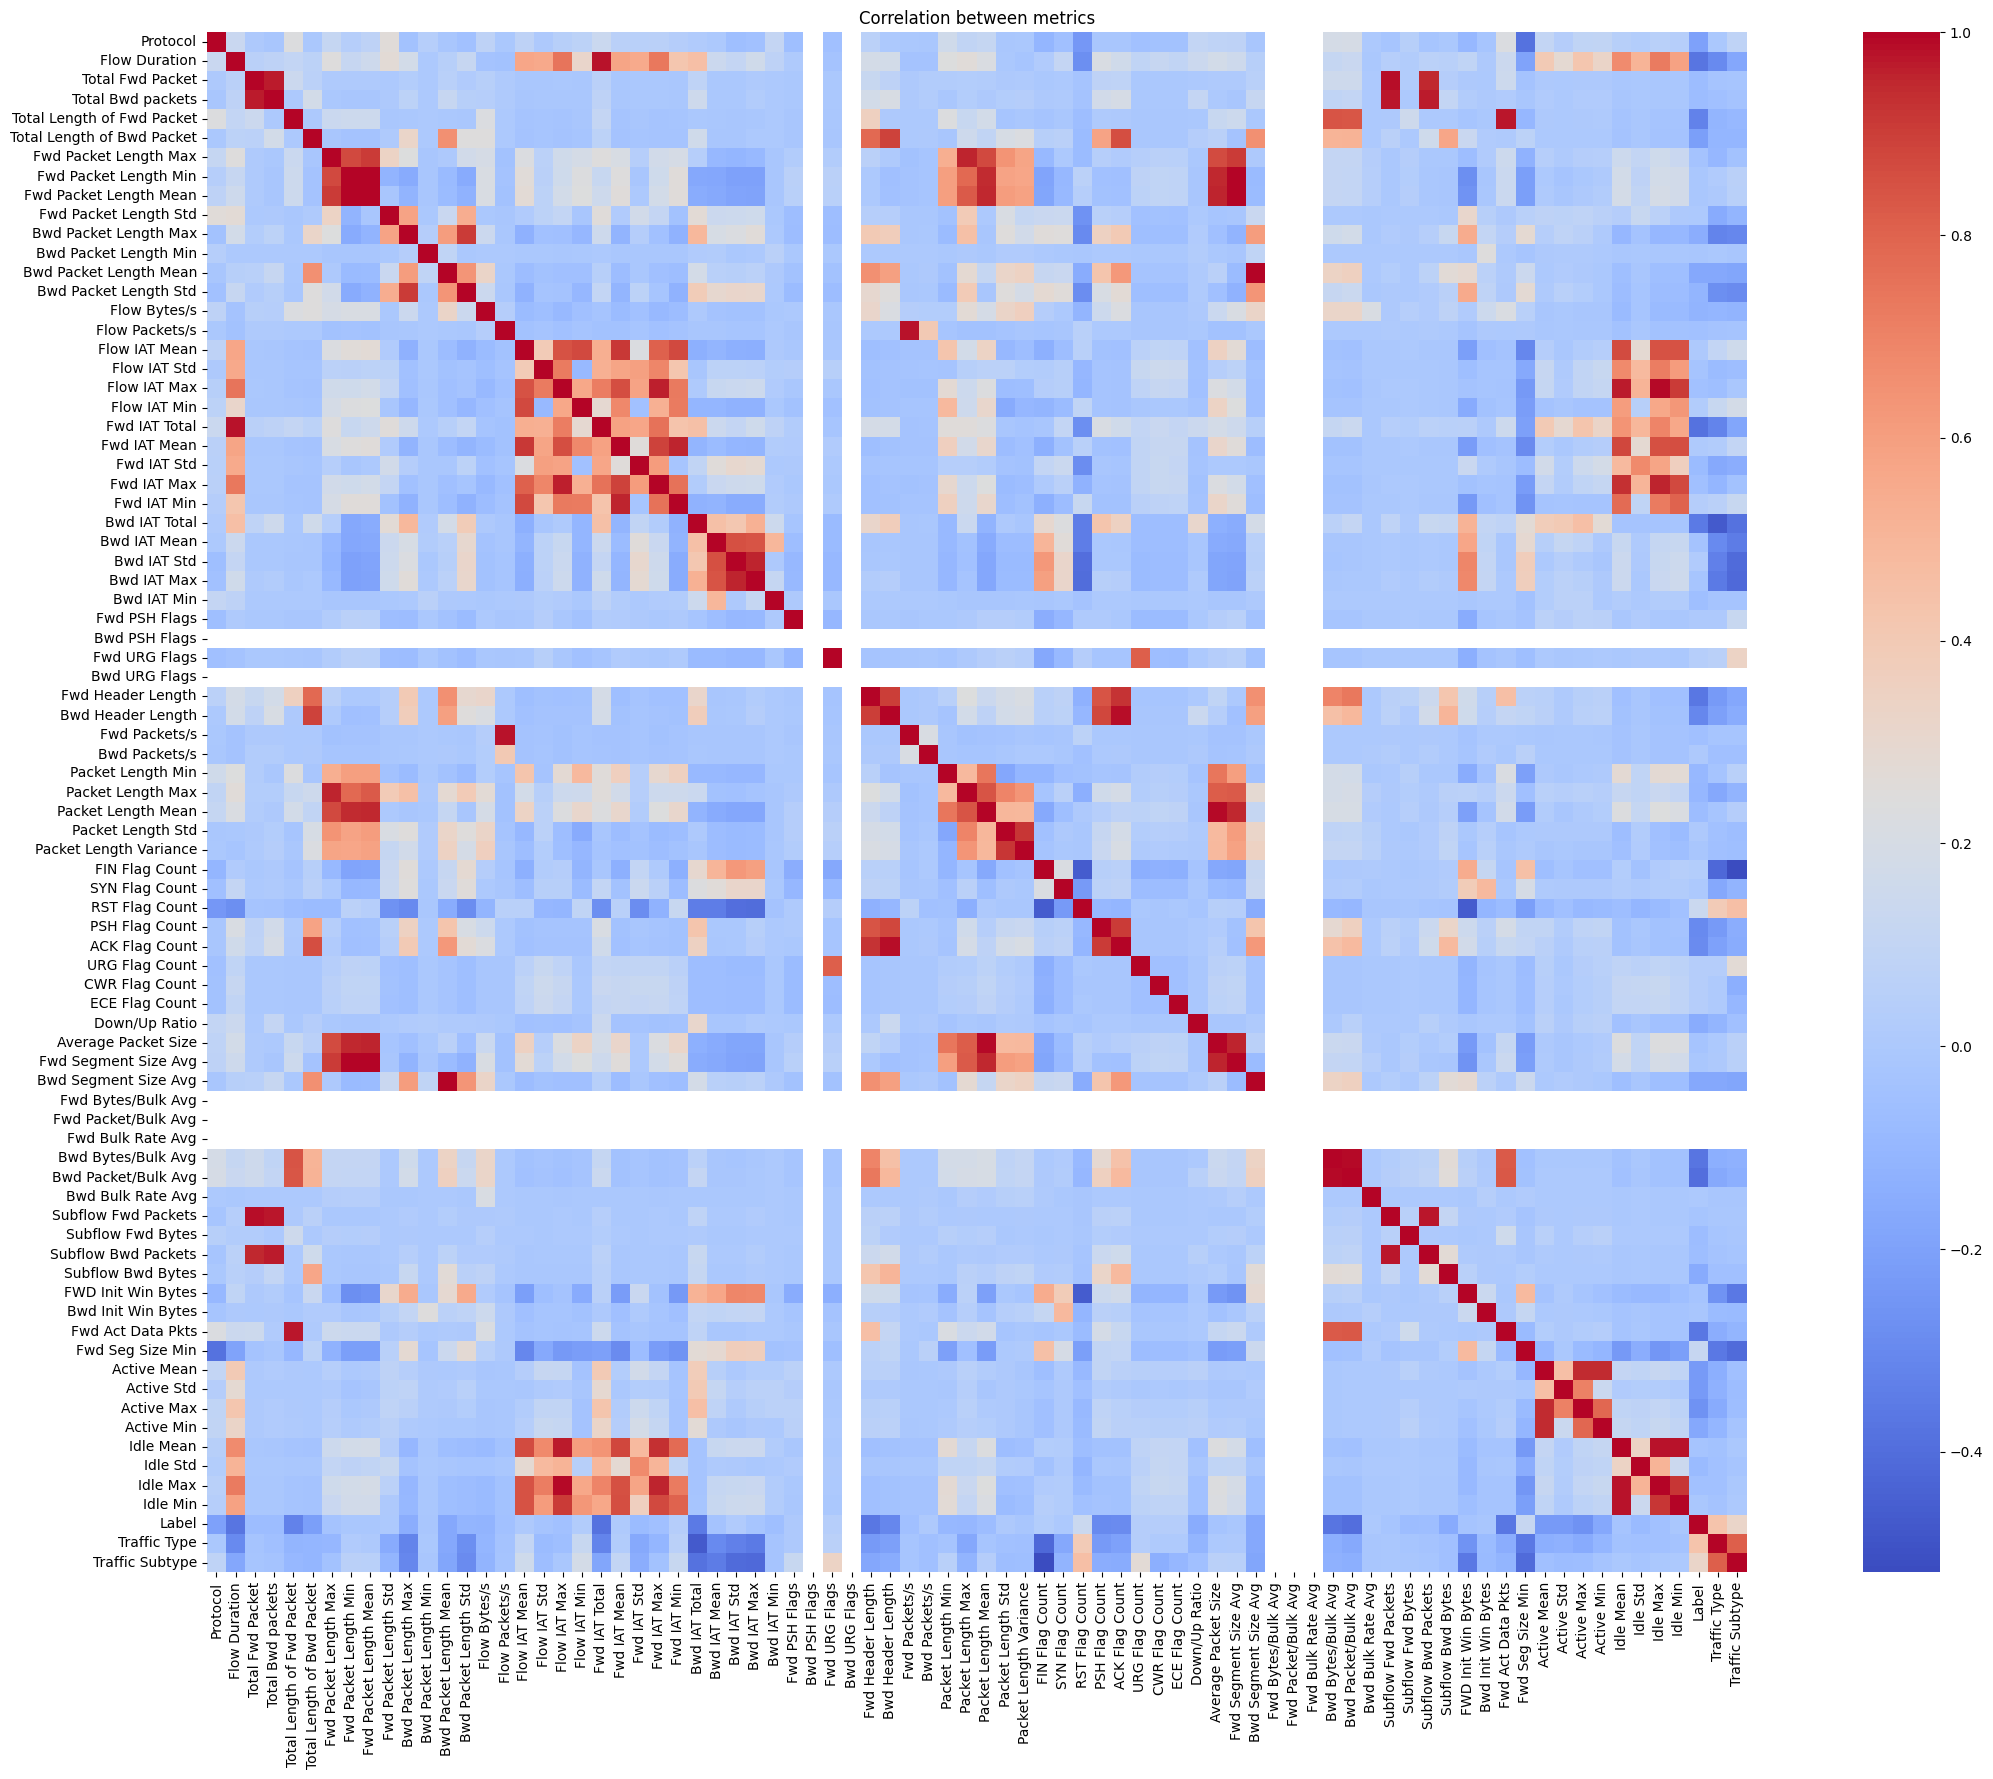

Generating heatmap ...


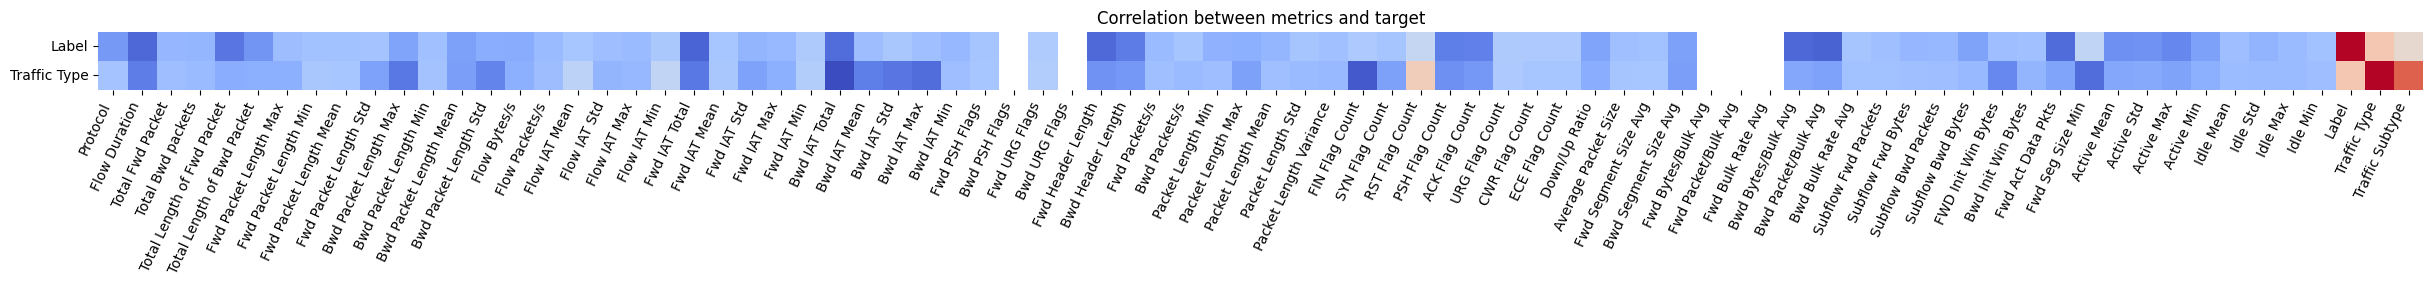

In [19]:
### PREPROCESSING (Implementation) - Create heatmaps
general_correlation = {"Correlation": cor}
heatmap(general_correlation, "Correlation between metrics")

targeted_correlation = {"Label": cor_label, "Traffic Type": cor_ttype}
heatmap(targeted_correlation, "Correlation between metrics and target", with_target=True)

Generating barplot ...


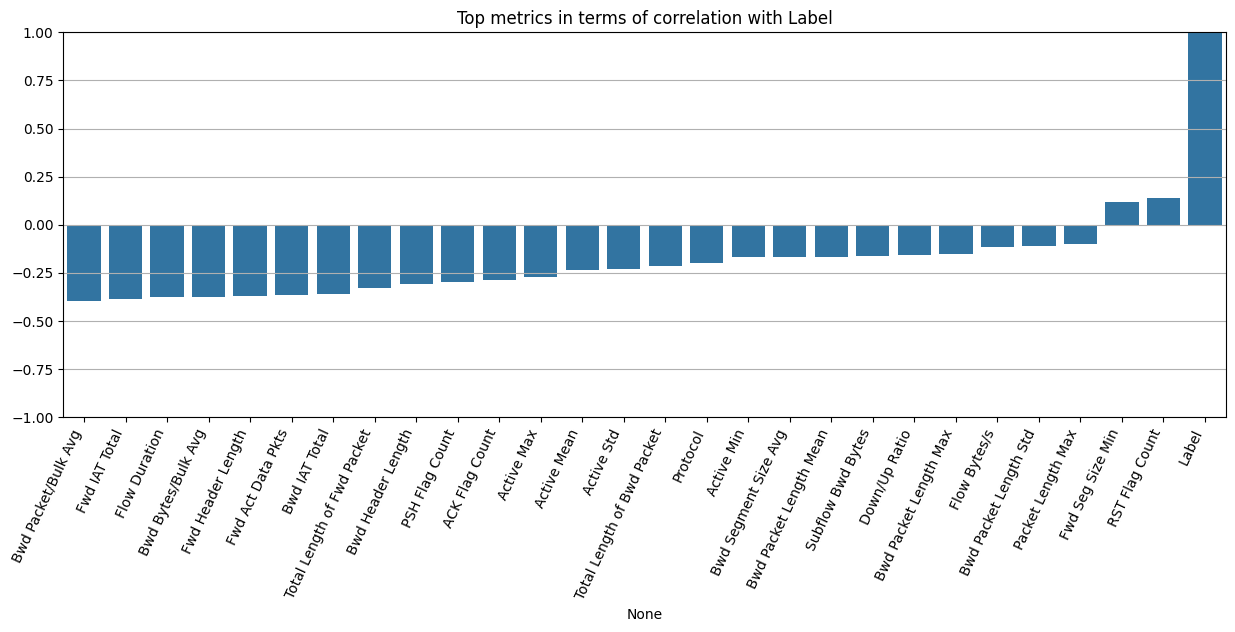

Generating barplot ...


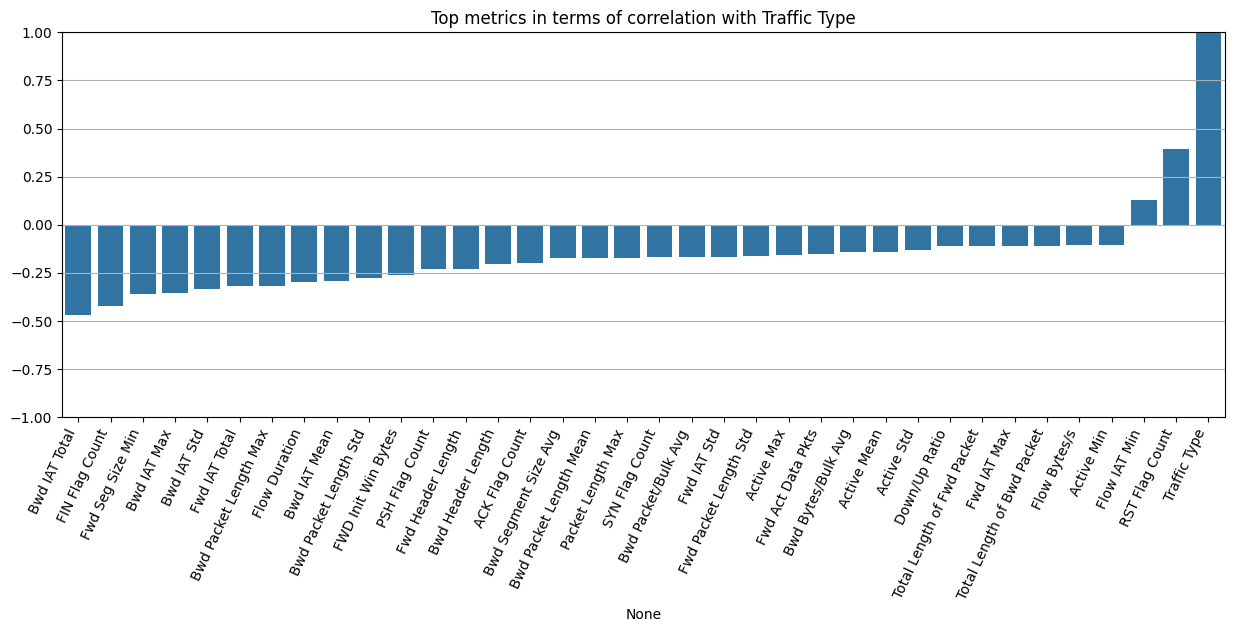

In [20]:
### PREPROCESSING (Implementation) - Showcase top correlations
df_important_metrics_label_count = cor_label.filter(items=label_barplot, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor_ttype.filter(items=ttype_barplot, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [21]:
### PREPROCESSING (Implementation) - DataFrames with metrics highly correlated with targets, dimension reduction
DIM_TARGET1 = 12
DIM_TARGET2 = 16
df_label = df[important_metrics_label].copy()
df_ttype = df[important_metrics_ttype].copy()

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=TARGET_LABELS), DIM_TARGET1, "PCA")
df_labelDimReduction["Label"] = df_label["Label"]
df_labelDimReduction["Traffic Type"] = df_label["Traffic Type"]
df_labelDimReduction["Traffic Subtype"] = df_label["Traffic Subtype"]
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=TARGET_LABELS), DIM_TARGET2, "PCA")
df_ttypeDimReduction["Label"] = df_ttype["Label"]
df_ttypeDimReduction["Traffic Type"] = df_ttype["Traffic Type"]
df_ttypeDimReduction["Traffic Subtype"] = df_ttype["Traffic Subtype"]


Target Label:
PCA METHOD --> Cumulative variance: 0.9461063928383165
Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.949192641906041


In [22]:
### PREPROCESSING (Implementation) - Sampling
df_label_sampling = sampling(df_labelDimReduction, 0.1, notext=True)
df_ttype_sampling = sampling(df_ttypeDimReduction, 0.1, notext=True)

In [23]:
### PREPROCESSING (Implementation) - Clustering with BIRCH
print("\nBIRCH with target: Label")
df_label_BIRCH, BIRCH_model_label = BIRCH_clustering(df_labelDimReduction.drop(columns=TARGET_LABELS), 2000, threshold=0.01)
df_label_BIRCH["Label"] = df_labelDimReduction["Label"]
df_label_BIRCH["Traffic Type"] = df_labelDimReduction["Traffic Type"]
print("\nBIRCH with target: Traffic Type")
df_ttype_BIRCH, BIRCH_model_ttype = BIRCH_clustering(df_ttypeDimReduction.drop(columns=TARGET_LABELS), 4000, threshold=0.005)
df_ttype_BIRCH["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]
df_ttype_BIRCH["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]


BIRCH with target: Label
2000 Clusters
Davies-Bouldin Index: 0.014510659690549875

BIRCH with target: Traffic Type
4000 Clusters
Davies-Bouldin Index: 0.017146271266535132


In [24]:
### PREPROCESSING (Implementation) - Clustering with HDBSCAN
print("\nHDBSCAN with target: Label")
df_label_HDBSCAN, HDBSCAN_model_label = HDBSCAN_clustering(df_labelDimReduction.drop(columns=TARGET_LABELS), 10)
df_label_HDBSCAN["Label"] = df_labelDimReduction["Label"]
df_label_HDBSCAN["Traffic Type"] = df_labelDimReduction["Traffic Type"]
print("\nHDBSCAN with target: Traffic Type")
df_ttype_HDBSCAN, HDBSCAN_model_ttype = HDBSCAN_clustering(df_ttypeDimReduction.drop(columns=TARGET_LABELS), 2)
df_ttype_HDBSCAN["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]
df_ttype_HDBSCAN["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]


HDBSCAN with target: Label
665 Clusters
Davies-Bouldin Index: 0.05888584560329295

HDBSCAN with target: Traffic Type
4877 Clusters
Davies-Bouldin Index: 0.06809279646978679


BIRCH, target = Label:
Problematic Cluster - Ratio: 0.200%
Population that belongs to Problematic Clusters - Ratio: 0.253%
Clusters assigned to each Label: {0: 354, 1: 1646}
Problematic Clusters assigned to each Label: {0: 0, 1: 4}
Total Clusters: 2000
Empty clusters: 0
Total Population predicted per Target: {0: 584, 1: 32198}
Real Population per Target: {0: 662, 1: 32120}


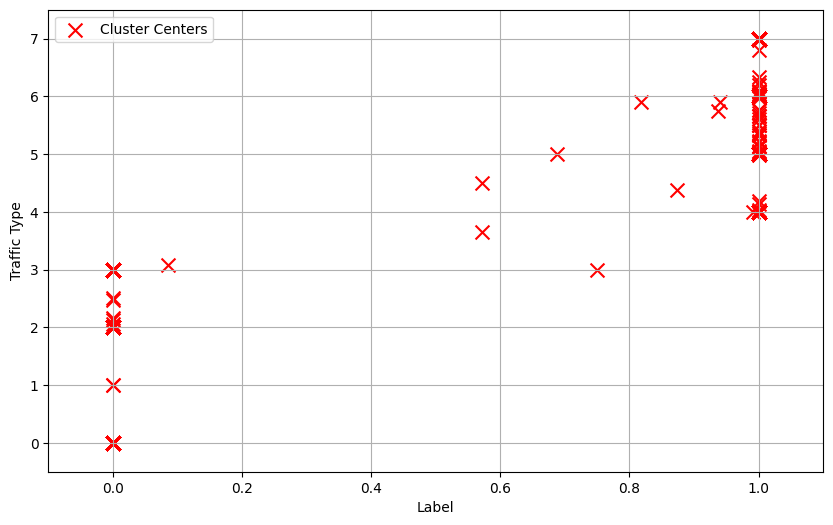

BIRCH, target = Traffic Type:
Problematic Cluster - Ratio: 1.200%
Population that belongs to Problematic Clusters - Ratio: 1.946%
Clusters assigned to each Traffic Type: {0: 85, 1: 0, 2: 86, 3: 198, 4: 318, 5: 3060, 6: 88, 7: 165}
Problematic Clusters assigned to each Traffic Type: {0: 1, 1: 0, 2: 3, 3: 3, 4: 3, 5: 26, 6: 1, 7: 11}
Total Clusters: 4000
Empty clusters: 0
Total Population predicted per Target: {0: 91, 1: 0, 2: 132, 3: 412, 4: 7056, 5: 19983, 6: 2865, 7: 2243}
Real Population per Target: {0: 106, 1: 14, 2: 113, 3: 429, 4: 6985, 5: 20016, 6: 2821, 7: 2298}


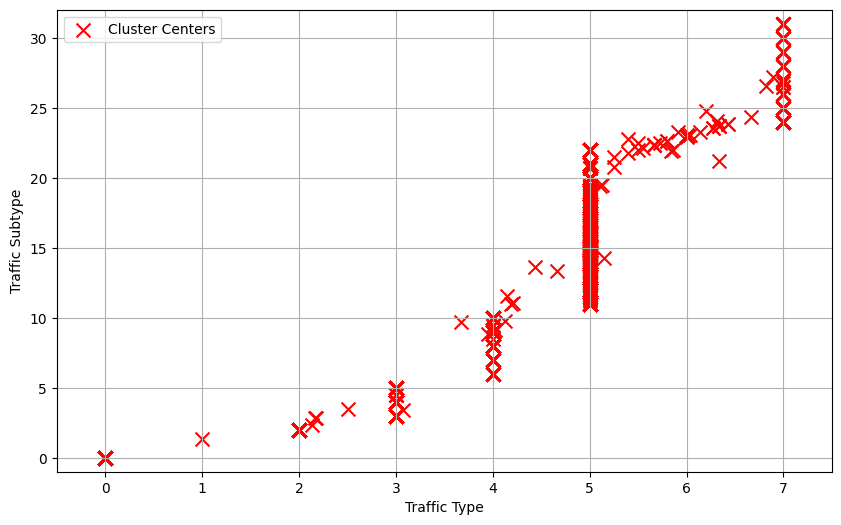

HDBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 0.450%
Population that belongs to Problematic Clusters - Ratio: 0.336%
Clusters assigned to each Label: {0: 14, 1: 651}
Problematic Clusters assigned to each Label: {0: 0, 1: 3}
Total Clusters: 666
Empty clusters: 1
Total Population predicted per Target: {0: 284, 1: 25681}
Real Population per Target: {0: 662, 1: 32120}


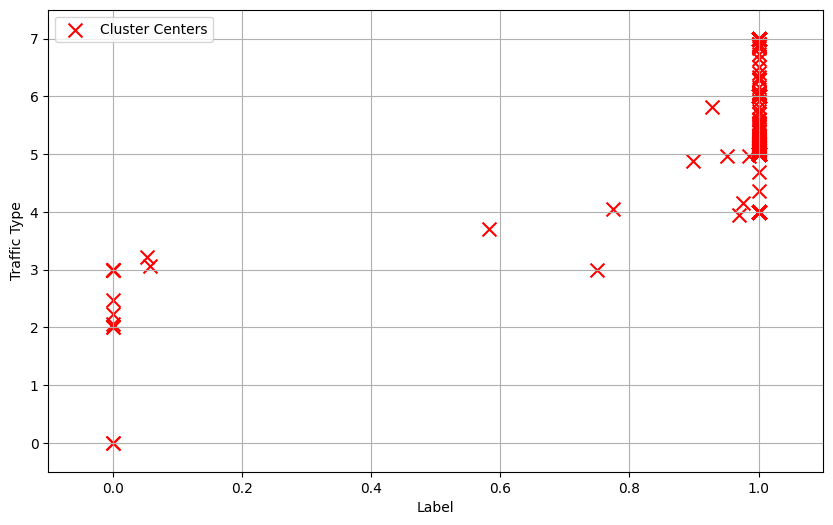

HDBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 1.620%
Population that belongs to Problematic Clusters - Ratio: 1.269%
Clusters assigned to each Traffic Type: {0: 15, 1: 1, 2: 18, 3: 64, 4: 681, 5: 3193, 6: 504, 7: 401}
Problematic Clusters assigned to each Traffic Type: {0: 5, 1: 1, 2: 8, 3: 9, 4: 17, 5: 23, 6: 4, 7: 12}
Total Clusters: 4878
Empty clusters: 1
Total Population predicted per Target: {0: 77, 1: 8, 2: 108, 3: 325, 4: 5648, 5: 16666, 6: 2486, 7: 1926}
Real Population per Target: {0: 106, 1: 14, 2: 113, 3: 429, 4: 6985, 5: 20016, 6: 2821, 7: 2298}


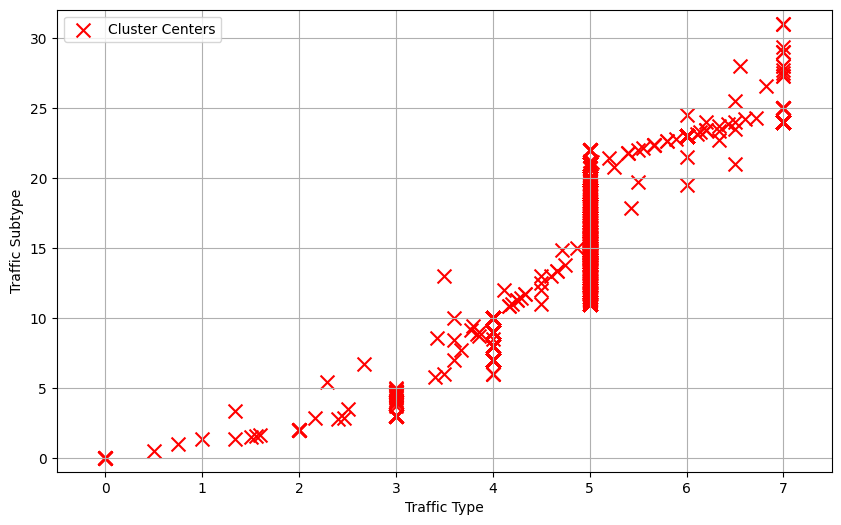

In [25]:
### PREPROCESSING (Implementation) - Visualize clusters and discard problematic ones

print("BIRCH, target = Label:")
df_label_BIRCH_cleaned = evaluate_clusters(df_label_BIRCH, "Label", "Traffic Type", 2, keep_problematic=False)
print("BIRCH, target = Traffic Type:")
df_ttype_BIRCH_cleaned = evaluate_clusters(df_ttype_BIRCH, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15, keep_problematic=False)

print("HDBSCAN, target = Traffic Type:")
df_label_HDBSCAN_cleaned = evaluate_clusters(df_label_HDBSCAN, "Label", "Traffic Type", 2, keep_problematic=False)
print("HDBSCAN, target = Traffic Type:")
df_ttype_HDBSCAN_cleaned = evaluate_clusters(df_ttype_HDBSCAN, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15, keep_problematic=False)

In [26]:
### PREPROCESSING (Implementation) - Produce samples for testing
testing_num = labels_to_numerical(df_test, LABEL_MAPPER)
testing_num = ttypes_to_numerical(testing_num, TYPES_MAPPER)
testing_num = subtypes_to_numerical(testing_num, SUBTYPES_MAPPER).sample(frac=1, ignore_index=True)

"""df_test, y_test = oversample(testing_num, "Traffic Type")
df_test["Traffic Type"] = y_test"""

df_test = testing_num

testing_label = dim_reduction(testing_num[important_metrics_label].drop(columns=TARGET_LABELS), DIM_TARGET1, "PCA", notext=True)
testing_label["Label"] = testing_num["Label"]

testing_ttype = dim_reduction(testing_num[important_metrics_ttype].drop(columns=TARGET_LABELS), DIM_TARGET2, "PCA", notext=True)
testing_ttype["Traffic Type"] = testing_num["Traffic Type"]

In [ ]:
### PREPROCESSING (Implementation) - Produce samples for training
# Sampling data
training_sampled_label = df_label_sampling.drop(columns=["Traffic Type", "Traffic Subtype"])
print("Sampling method for Label: {0} samples".format(len(training_sampled_label)))
training_sampled_ttype = df_ttype_sampling.drop(columns=["Label", "Traffic Subtype"])
print("Sampling method for Traffic Type: {0} samples".format(len(training_sampled_ttype)))

# BIRCH datadf_label_BIRCH
training_BIRCH_label = format_data(df_label_BIRCH_cleaned.drop(columns=["Traffic Type"]), "Label", 2)
print("Sampling method for Label: {0} samples".format(len(training_BIRCH_label)))
training_BIRCH_ttype = format_data(df_ttype_BIRCH_cleaned.drop(columns=["Traffic Subtype"]), "Traffic Type", 8)
print("Sampling method for Traffic Type: {0} samples".format(len(training_BIRCH_ttype)))

# HDBSCAN data
training_HDBSCAN_label = format_data(df_label_HDBSCAN_cleaned.drop(columns=["Traffic Type"]), "Label", 2)
print("Sampling method for Label: {0} samples".format(len(training_HDBSCAN_label)))
training_HDBSCAN_ttype = format_data(df_ttype_HDBSCAN_cleaned.drop(columns=["Traffic Subtype"]), "Traffic Type", 8)
print("Sampling method for Traffic Type: {0} samples".format(len(training_HDBSCAN_ttype)))

Sampling method for Label: 3278 samples
Sampling method for Traffic Type: 3278 samples
Sampling method for Label: 3281 samples
Sampling method for Traffic Type: 24285 samples
Sampling method for Label: 1295 samples
Sampling method for Traffic Type: 25370 samples


PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11  PC12  \
0 -0.88 -0.85  0.21 -1.01 -0.75 -0.18 -0.31  1.12  0.13 -0.47 -0.44  0.04   
1  0.17  0.14 -0.64  0.77  0.19  1.38  0.55 -0.94  0.03  0.03  0.37 -0.40   
2 -0.32 -0.15  0.07  0.25  0.38 -0.22  0.10 -0.77 -0.01  0.21  0.13  0.15   
3 -0.39  0.81  0.26 -0.72 -0.32 -0.26 -0.16  0.10 -0.36 -0.23  0.27 -0.41   
4 -0.72 -0.38  0.28 -0.96 -0.17 -0.23 -0.65  1.18  0.11 -0.37 -0.17 -0.28   

   Label  
0      1  
1      1  
2      1  
3      1  
4      1

PC1   PC2  PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11  PC12  \
0 -0.41  0.95 0.25 -0.83 -0.82 -0.29  0.04  0.05 -0.53 -0.29  0.21 -0.23   
1  2.21 -0.21 5.05  2.10  0.85 -3.54  1.85 -1.88  0.78  1.06 -1.93  1.72   
2  0.58  2.02 1.57  1.05  3.82 -4.00  0.62 -1.85  0.69 -0.40 -1.08  1.17   
3  1.01  3.57 1.74  1.06  4.89 -4.19 -0.11 -1.76  0.43 -0.18 -0.37  0.46   
4  0.36  3.44 1.65 -0.23  1.22 -3.67  1.97 -2.34 -0.20 -1.28 -0.97  0.56   

   Label  
0      1  
1      0  
2      1  
3      1  
4      1

PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11  PC12  \
0 -0.80 -0.62  0.24 -0.98 -0.47 -0.21 -0.48  1.15  0.12 -0.42 -0.31 -0.12   
1 -0.70 -0.65  0.14 -0.54 -0.38 -0.03  0.23  0.20  0.11 -0.27 -0.19 -0.10   
2  2.66  1.07 -2.64  4.54  0.84  0.87 -0.35  0.18 -0.38 -0.74  0.19  1.75   
3  0.37  0.31  0.37 -0.20 -0.14 -0.09  0.02 -0.03  0.06  0.06 -0.01 -0.08   
4  8.34  0.23 16.24  4.91  1.53 -0.69 -0.26 -0.47  0.46 -1.05  0.22  0.46   

   Label  
0      1  
1      1  
2      1  
3      1  
4      0

In [28]:
### TRAINING/TESTING (Imports) - Import necessary libraries for training and testing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import SVC

In [29]:
### TRAINING/TESTING (Function definitions) - Dataloader
def generate_dataloader(df_train: pd.DataFrame, df_test: pd.DataFrame, target: str, batch_size=32) -> DataLoader:
    y_train = df_train[target]
    x_train = df_train.drop(columns=[target])
    y_test = df_test[target]
    x_test = df_test.drop(columns=[target])

    x_train_tensor = torch.tensor(np.array(x_train), dtype=torch.float32)
    x_test_tensor = torch.tensor(np.array(x_test), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
    y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    training_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testing_data = DataLoader(test_dataset, batch_size=batch_size)

    return training_data, testing_data

In [30]:
### TRAINING/TESTING (Class/Functions definitions) - Neural Network
class NeuralNetwork_2hid(nn.Module):
    def __init__(self, input_dim, output_dim, dim1, dim2):
        super(NeuralNetwork_2hid, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, dim1),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(dim1, dim2),
            nn.Tanh(),
            nn.Linear(dim2, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)
    
class NeuralNetwork_3hid(nn.Module):
    def __init__(self, input_dim, output_dim, dim1, dim2, dim3):
        super(NeuralNetwork_3hid, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, dim1),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(dim1, dim2),
            nn.Tanh(),
            nn.Linear(dim2, dim3),
            nn.Tanh(),
            nn.Linear(dim3, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def NeuralNetworkClassification(df_train: pd.DataFrame, df_test: pd.DataFrame, target, batch_size=32, epochs=50, lr=0.005, nn_hid=(64, 64)) -> None:

    # Generate dataloader
    train_data_sampling, test_data_sampling = generate_dataloader(df_train, df_test, target, batch_size=batch_size)

    input_dim = df_train.shape[1] - 1
    if target == 'Label': 
        output_dim = 2
        labels = ["Benign", "Malicious"]
    elif target == 'Traffic Type': 
        output_dim = 8
        labels = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]

    # Neural Network model, loss functions and optimizer
    if len(nn_hid) == 2:
        model = NeuralNetwork_2hid(input_dim, output_dim, nn_hid[0], nn_hid[1])
    elif len(nn_hid) == 3:
        model = NeuralNetwork_3hid(input_dim, output_dim, nn_hid[0], nn_hid[1], nn_hid[2])
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_data_sampling:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_function(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if epoch % 10 == 0: print(f"Epoch {epoch}/{epochs} -> Loss: {total_loss:.4f}")

    # Testing
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_data_sampling:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Accuracy and classification report
    print(f"Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    confusion_matrix_nn = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix_nn, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {target}")
    plt.show()

Epoch 0/100 -> Loss: 2.7555
Epoch 10/100 -> Loss: 2.6822
Epoch 20/100 -> Loss: 2.6005
Epoch 30/100 -> Loss: 2.5085
Epoch 40/100 -> Loss: 2.4048
Epoch 50/100 -> Loss: 2.2958
Epoch 60/100 -> Loss: 2.1918
Epoch 70/100 -> Loss: 2.0875
Epoch 80/100 -> Loss: 1.9977
Epoch 90/100 -> Loss: 1.9242
Test Accuracy: 96.57%
              precision    recall  f1-score   support

           0       0.37      0.75      0.49       457
           1       0.99      0.97      0.98     20032

    accuracy                           0.97     20489
   macro avg       0.68      0.86      0.74     20489
weighted avg       0.98      0.97      0.97     20489



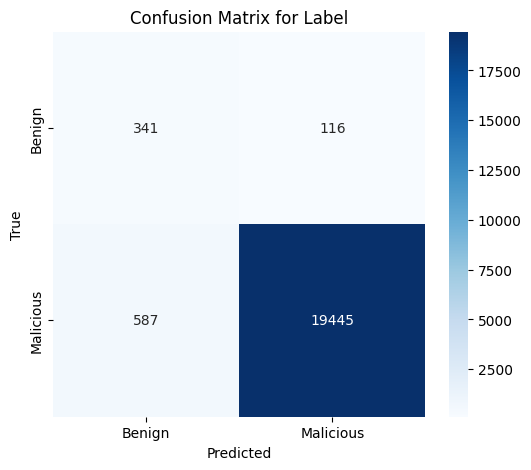

In [33]:
NeuralNetworkClassification(pd.concat([training_sampled_label, training_BIRCH_label, training_HDBSCAN_label], ignore_index=True), testing_label, 'Label', batch_size=2048, lr=1e-4, epochs=100)

Epoch 0/80 -> Loss: 20.0152
Epoch 10/80 -> Loss: 2.9888
Epoch 20/80 -> Loss: 1.4209
Epoch 30/80 -> Loss: 1.1056
Epoch 40/80 -> Loss: 1.0077
Epoch 50/80 -> Loss: 0.9639
Epoch 60/80 -> Loss: 0.9504
Epoch 70/80 -> Loss: 0.9371
Test Accuracy: 76.84%
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        65
           1       0.00      0.00      0.00        14
           2       0.17      0.54      0.26        80
           3       0.18      0.67      0.28       298
           4       0.82      0.64      0.71      4355
           5       0.94      0.83      0.88     12463
           6       0.38      0.65      0.48      1758
           7       0.78      0.80      0.79      1456

    accuracy                           0.77     20489
   macro avg       0.48      0.59      0.50     20489
weighted avg       0.84      0.77      0.79     20489



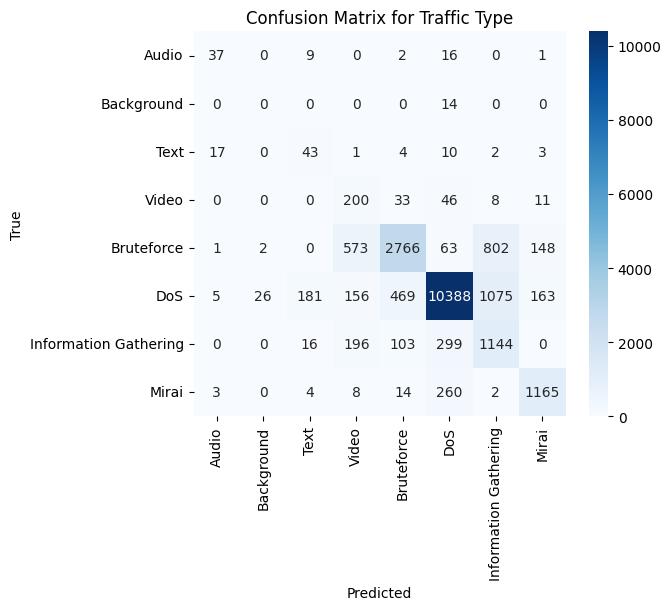

In [34]:
NeuralNetworkClassification(pd.concat([training_sampled_ttype, training_BIRCH_ttype, training_HDBSCAN_ttype]), testing_ttype, 'Traffic Type', batch_size=4096, epochs=80, lr=1e-2, nn_hid=(128, 64, 8))

In [35]:
def SVM_classification(df_train: pd.DataFrame, df_test: pd.DataFrame, target: str, kernel='rbf', C=1.0, grid_search=False) -> None:
    # Seperate inputs and outputs
    y_train = df_train[target]
    x_train = df_train.drop(columns=[target])
    y_test = df_test[target]
    x_test = df_test.drop(columns=[target])

    if target == 'Label': 
        labels = ["Benign", "Malicious"]
        decision_function = 'ovo'
    elif target == 'Traffic Type': 
        labels = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]
        decision_function = 'ovr'

    # Grid search for best parameters (suboptimal, overheats computer)
    if grid_search == True:
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1],
            'kernel': ['rbf', 'linear']
        }

        grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
        grid.fit(x_train, y_train)

        print("Best Parameters:")
        print(grid.best_params_)
        print(f"Best CV Accuracy: {grid.best_score_ * 100:.2f}%")

        best_model = grid.best_estimator_
        y_pred = best_model.predict(x_test)
    
    # Initialize SVM
    else:
        clf = SVC(kernel=kernel, C=C, gamma='scale', class_weight='balanced', decision_function_shape=decision_function)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

    #Accuracy and classification report
    
    print(f"\nSVC Accuracy for '{target}': {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix and its labels
    confusion_matrix_svm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix 
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"SVC Confusion Matrix for {target}")
    plt.show()


SVC Accuracy for 'Label': 95.34%
              precision    recall  f1-score   support

           0       0.28      0.68      0.40       457
           1       0.99      0.96      0.98     20032

    accuracy                           0.95     20489
   macro avg       0.64      0.82      0.69     20489
weighted avg       0.98      0.95      0.96     20489



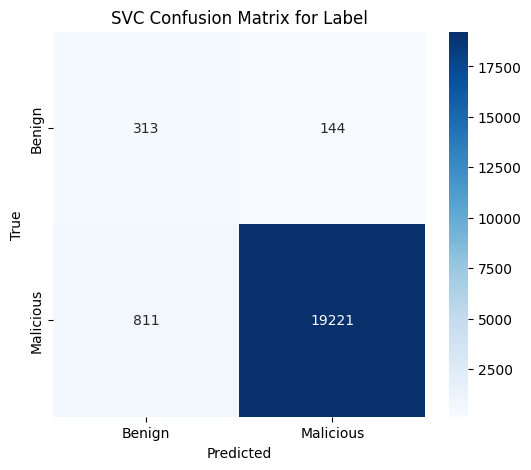

In [36]:
SVM_classification(pd.concat([training_sampled_label, training_BIRCH_label, training_HDBSCAN_label]), testing_label, "Label", kernel="linear", C=0.1)


SVC Accuracy for 'Traffic Type': 63.51%
              precision    recall  f1-score   support

           0       0.32      0.66      0.43        65
           1       0.00      0.00      0.00        14
           2       0.03      0.33      0.05        80
           3       0.13      0.70      0.22       298
           4       0.98      0.28      0.43      4355
           5       0.95      0.73      0.82     12463
           6       0.36      0.79      0.49      1758
           7       0.35      0.75      0.47      1456

    accuracy                           0.64     20489
   macro avg       0.39      0.53      0.36     20489
weighted avg       0.84      0.64      0.67     20489



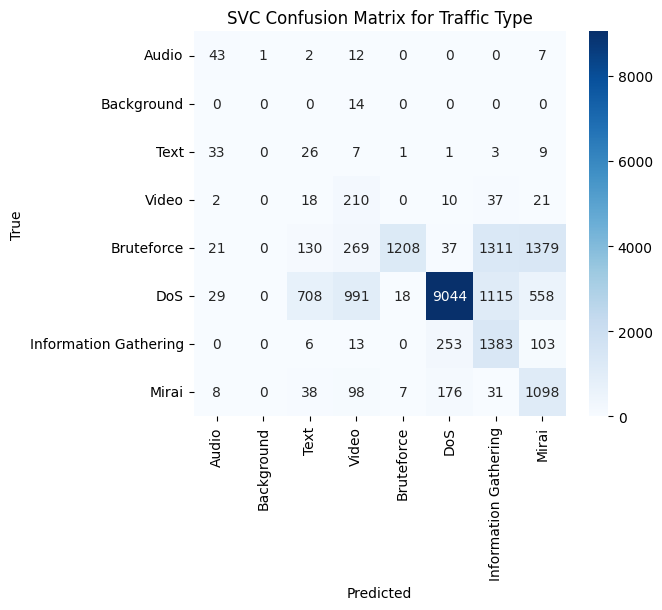

In [37]:
SVM_classification(pd.concat([training_sampled_ttype, training_BIRCH_ttype, training_HDBSCAN_ttype]), testing_ttype, "Traffic Type", kernel="linear", C=0.1)